# Third Script:
1. Create Embeddings for existings dataset of reviews, using Doc_2_vec model.
2. "Match" the embeddings for the future machines - normalize, convert type' etc.
3. Run some cosine similarty tests
4. Make some adjusments to the dataset and export it back

In [ ]:
!pip install pandas gensim matplotlib
!pip install pytz
!pip install transformers

In [ ]:
import nltk
nltk.download('words')
import pandas as pd
import numpy as np
import random
from nltk.corpus import words
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf
from tqdm.notebook import tqdm
tqdm.pandas()
import os
import re
from IPython.display import display


#import embedding
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Mount Google Drive
from google.colab import drive
drive.mount('/gdrive')
# drive.mount('/content/drive')
# !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1FCU6Y-6uab9X06OsqU9QRcerr_S7Mbez' -O settings.txt
import seaborn as sns
import matplotlib.pyplot as plt

# Datetime
from datetime import datetime
import time
import pytz

# Threading package
import concurrent.futures
import multiprocessing
import pickle

# Statistics package
from scipy.stats import ttest_ind

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


# General Methods

In [ ]:
def tokenize_df_reviews_doc2vec(reviews_dataset=None):
  """
  :param reviews_dataset (dataframe) - dataframe including a column of texts (reviewText)
  Returns the reviews_dataset including column of embedded numerical vectors (by tensor flow) of the text (Numpy Array)
  plot a histogram of 1000 Random Pairs of Texts
  """

  # 1. Prepare data for training Doc2Vec. TaggedDocument expects words and tags. We'll use row indices as tags.
  # documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(reviews_dataset['reviewText'].apply(lambda x: x.split()))]
  documents = [TaggedDocument(words=text.split(), tags=[index])  for index, text in reviews_dataset['reviewText'].iteritems()]
  # for index, text in reviews_dataset['reviewText'].iteritems()

  # print(f'documents:\n{documents}')
  # 2. Train a Doc2Vec model
  model = Doc2Vec(vector_size=50, window=5, min_count=1, workers=4, epochs=100)
  model.build_vocab(documents)
  model.train(documents, total_examples=model.corpus_count, epochs=model.epochs)

  # 3. Add a column of embeddings to reviews_dataset
  reviews_dataset['doc2vec_embedding'] = reviews_dataset['reviewText'].apply(lambda x: model.infer_vector(x.split()))
  reviews_dataset['doc2vec_dv'] = reviews_dataset.index.map(lambda x: model.dv[x])
  # .index.map(lambda x: model.dv[x])
  # model.dv[i]


  display(df)

  return reviews_dataset, model


In [ ]:
def check_normalized_vectors(df, vec_col='doc2vec_embedding'):
    """
    Checks if the vectors in the 'Bert_tf_vec' column of the input dataframe are normalized.

    Parameters:
    df (pandas.DataFrame): Input dataframe containing the 'Bert_tf_vec' column.

    Returns:
    dict: Dictionary with keys representing the row indices of the non-normalized vectors
          and values representing the corresponding vector norms.
    """

    non_normalized_dict = {}
    for index, row in df.iterrows():
        vector = row[vec_col]
        norm = np.linalg.norm(vector)
        if norm != 1.0:
            non_normalized_dict[index] = norm

    return non_normalized_dict



def cosine_similarity(a, b):
  """
  :param a (Numpy array) - numerical vector
  :param b (Numpy array) - numerical vector
  Returns  the cosine similarity over 2 vectors (numerical - [0,1]). 1 - The same, 0 - 100% opposit
  """
  nominator = np.dot(a, b.T)

  a_norm = np.sqrt(np.sum(a**2))
  b_norm = np.sqrt(np.sum(b**2))

  denominator = a_norm * b_norm

  cosine_similarity = float(nominator / denominator)

  return cosine_similarity


def add_cosine_sim_col(df, vec_col='doc2vec_embedding'):
  # Apply 'cosine_similarity' function with 'Review' value from the first row as an argument and add 'cosine_sim' column
  df['cosine_sim'] = df[vec_col].progress_apply(cosine_similarity, args=(df[vec_col][0],))

  return(df)



def normalize_vectors(df, vec_col='doc2vec_embedding'):
  """
  Normalizes the vectors in the embedded column of the input dataframe.
  """

  # Create a copied dataframe
  normalized_df = df.copy()

  # Create a new dataframe with the normalized vectors
  normalized_df[vec_col] = df[vec_col].apply(lambda x: x / np.linalg.norm(x))
  # print(f'The vector has been normalized.\nCheck_normalized vectors:{check_normalized_vectors(df=normalized_df)}')
  return normalized_df



def plot_line_cos_sim(df, cosine_sim_col='cosine_sim', add_heading="(doc2vec)"):
  # Set seaborn style
  sns.set(style="whitegrid")

  # Plotting the graph
  plt.figure(figsize=(8, 6))
  sns.lineplot(data=df, x='Index', y=cosine_sim_col, marker='o')
  plt.xlabel('Number of Changing Words')
  plt.ylabel('Cosine Similarity')
  plt.title('Cosine Similarity (model.dv) vs. Number of Changing Words '+ add_heading)
  plt.tight_layout()
  plt.show()


def execute(df):
  """
  run check_normalized_vectors, add_cosine_sim_col, normalize_vectors on df
  """
  # tokenize the df
  df, model=tokenize_df_reviews_doc2vec(reviews_dataset=df)

  # check wether the embeddings are normalized
  check_normalized_vectors(df=df)

  # normalize the vectors
  df=normalize_vectors(df)

  # add a column of cosine sim to the first row
  # df=add_cosine_sim_col(df=df)
  df=add_cosine_sim_col(df=df,vec_col='doc2vec_dv')

  return df, model


def n_averages_cos_sim(n=200, cosine_sim_col='cosine_sim'):
  """
  create an averages of the cosine_sim over n 100 text variations
  plot a line plot of the averages
  """
  #create an empty serie to sum all the cosin_sims
  df_averages = pd.DataFrame(index=range(101))
  df_averages.index.name = 'Index'

  # Add columns 'cos_sim_sum' and 'averages' filled with NaN values
  df_averages['cos_sim_sum'] = 0.0
  # df_averages['averages'] = pd.np.nan

  for i in range(0, n):
    # each iteration create a ne 100 words varitions
    df=create_100_words_text_variations()

    # exectue all the methods
    df, model=execute(df)
    # print(f'df:\n{df}')
    # add the cos_sim to the sum
    # print(f'df.dtypes: {df.dtypes}')
    # print(f'df[cosine_sim_col].dtype: {df[cosine_sim_col].dtype}\ndf_averages["cos_sim_sum"].dtype: {df_averages["cos_sim_sum"].dtype}')
    df_averages['cos_sim_sum']+= df[cosine_sim_col].values

    # average the cos_sim
    df_averages['averages']=df_averages['cos_sim_sum']/n

  return df_averages




In [ ]:
# create 100 words df
df=create_100_words_text_variations()

df, model = execute(df)

display(df)

# # tokenize the df
# df=tokenize_df_reviews_doc2vec(reviews_dataset=df)

# # check wether the embeddings are normalized
# check_normalized_vectors(df=df)

# # normalize the vectors
# df=normalize_vectors(df)

# # add a column of cosine sim to the first row
# df=add_cosine_sim_col(df=df)

# plot a lineplot of the cosinesim
plot_line_cos_sim(df=df)

# plot a lineplot of the n_average_cosinesim

In [ ]:
df_n=n_averages_cos_sim(n=50)

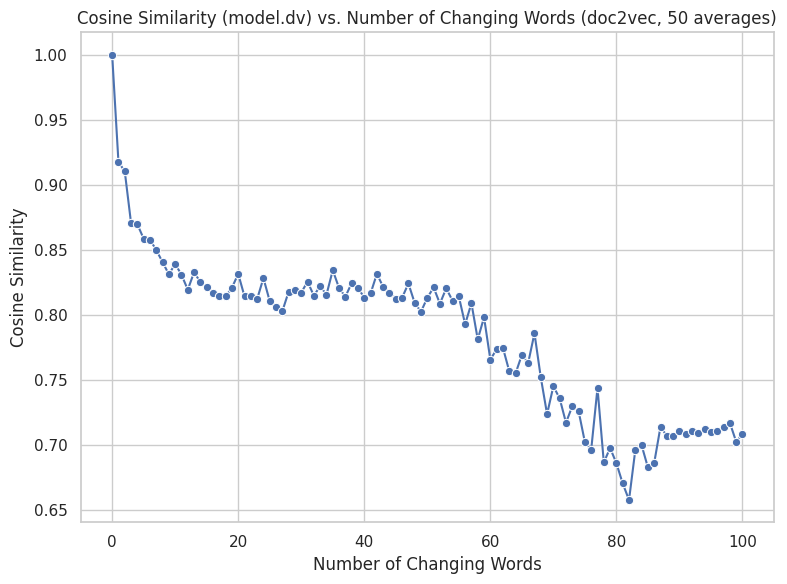

In [ ]:
plot_line_cos_sim(df_n, cosine_sim_col='averages', add_heading="(doc2vec, 50 averages)")

# Class of embedding and learn a csv files

In [ ]:
class Embedded_dataset_doc2vec:

      def __init__(self, name=None, csv_file='/balanced_labeled_dataset', path='/gdrive/My Drive/Amazon/results/', dataset=pd.DataFrame(data=None) ):
        """
        a class to create embeddings for a given dataset (dataframe). Can be given also  as name of a dataset + path.

        Input
        - name: The name of the Dataset
        - path: Pass to the directory of the csv file
        - dataset: Optional (instead of directory to the dataset - push directly a dataset)
        """
        self.name = name
        self.path = path # assign the given directory as path
        self.csv_file = csv_file # assign which file to execute
        self.reviews_dataset = dataset #  dataframe of reviews and labels (1 - left handed, 0 - right handed (general population))
        self.start_time = time.time()
        self.model = None


      def execute(self):
        """
        Runs the next methods:
        - verify_dataframe: verify that the dataset is in the correct format.
        - get_embedding: create a column of embedded vectors according to doc2vec.
        - normalize_vectors: normalize the column of the embedded vectors.
        - export_results: create a new csv file in the assigned path
        """

        zero_time = time.time() # calculate time of running


        if self.name is not None:
          # push the dataframe from the directory - only if a name ws given.
          self.reviews_dataset = pd.read_csv(self.path+self.name+self.csv_file+'.csv') # read left ID's reviews csv

        # print(f'self.reviews_dataset.shape(): \n{self.reviews_dataset.shape}\n')
        # stop the execution if the dataset is not in the right format.
        if not self.verify_dataframe():
          return

        # slice the reviews column
        # reviews = self.reviews_dataset['reviewText']

        print(f"started tokenizing: {time.time()-zero_time:.3f} seconds")

        self.tokenize_df_reviews_doc2vec()

        print(f"Embedding length: {len(self.reviews_dataset['doc2vec_embedding'])}\n")



        print(f"finished tokenizing: {time.time()-zero_time:.3f} seconds")
        # print(f'Type of embeddings: {type(embeddings)}, \nreviews: \n{embeddings}')

        # normalize the embeddings
        self.normalize_vectors()


        #if the dataset is part of a known category - export it
        if self.name is not None:
          self.export_results()


        elif self.name is None:
          self.name = '100_words_tests'
          self.export_results()


      def tokenize_df_reviews_doc2vec(self, reviews_dataset=None):
        """
        :param reviews_dataset (dataframe) - dataframe including a column of texts (reviewText)
        Returns the reviews_dataset including column of embedded numerical vectors (by tensor flow) of the text (Numpy Array)
        """

        reviews_dataset = self.reviews_dataset

        # Function to clean text
        def clean_text(text):
            text = text.lower()  # Convert text to lowercase
            text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
            return text


        # Apply the clean_text function to the 'reviewText' column
        reviews_dataset['reviewText'] = reviews_dataset['reviewText'].apply(clean_text)


        # 1. Prepare data for training Doc2Vec. TaggedDocument expects words and tags. We'll use row indices as tags.
        documents = [TaggedDocument(words=text.split(), tags=[index])  for index, text in reviews_dataset['reviewText'].iteritems()]
        # documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(reviews_dataset['reviewText'].apply(lambda x: x.split()))]

        # 2. Train a Doc2Vec model
        model = Doc2Vec(vector_size=50, window=5, min_count=1, workers=4, epochs=100)
        model.build_vocab(documents)
        model.train(documents, total_examples=model.corpus_count, epochs=model.epochs)

        # 3. Add a column of embeddings to reviews_dataset
        # reviews_dataset['doc2vec_embedding'] = reviews_dataset['reviewText'].apply(lambda x: model.infer_vector(x.split()))
        reviews_dataset['doc2vec_embedding'] = reviews_dataset.index.map(lambda x: model.dv[x])

        # Get the size of the corpus
        corpus_size = len(model.wv)
        print(f"Size of vocabulary: {corpus_size}")

        self.reviews_dataset = reviews_dataset
        self.model = model


      def normalize_vectors(self):
        """
        Normalizes the vectors in the 'Bert_tf_vec' column of the input dataframe.
        """

        # Create a copied dataframe
        normalized_df = self.reviews_dataset.copy()

        # Create a new dataframe with the normalized vectors
        self.reviews_dataset['doc2vec_embedding'] = normalized_df['doc2vec_embedding'].apply(lambda x: x / np.linalg.norm(x))
        print(f'The vector has been normalized\n')

        # return normalized_df


      def verify_dataframe(self):
          """
          Verifies the given dataframe based on specific conditions.

          Returns:
          bool: True if all conditions are met, False otherwise.
          """

          dataframe = self.reviews_dataset

          # Verify the presence of the 'reviewText' column
          if 'reviewText' not in dataframe.columns:
              print("The given dataframe doesn't have 'reviewText' column")
              return False

          review_text_column = dataframe['reviewText']

          # Verify if 'reviewText' column contains mostly strings
          # if not review_text_column.apply(lambda x: isinstance(x, str)).all():
          if not dataframe['reviewText'].apply(lambda x: isinstance(x, str)).all():
              print("The given dataframe's 'reviewText' column has cells which are not strings")

              # Identify non-string cells
              # non_string_cells = review_text_column.apply(lambda x: type(x) is not str)
              non_string_cells = dataframe['reviewText'].apply(lambda x: type(x) is not str)

              # Get the indices and values of non-string cells
              non_string_indices = dataframe.index[non_string_cells].tolist()
              non_string_values = dataframe.loc[non_string_cells, 'review_text_column'].tolist()

              # Print them out
              for idx, val in zip(non_string_indices, non_string_values):
                  print(f"Index: {idx}, Value: {val}, Type: {type(val)}")
              return False

          # Verify the presence of the 'label' column
          if 'label' not in dataframe.columns:
              print("The given dataframe doesn't have 'label' column")
              return False

          label_column = dataframe['label']

          # Verify if 'label' column contains only 0 or 1
          if not label_column.isin([0, 1]).all():
              print("The given dataframe's 'label' column contains values other than 0 or 1")
              return False

          # All verification conditions met
          print("The given dataframe meets all the required conditions")
          return True


      @staticmethod
      def cosine_similarity(a, b):
          """
          :param a (Numpy array) - numerical vector
          :param b (Numpy array) - numerical vector
          Returns  the cosine similarity over 2 vectors (numerical - [0,1]). 1 - The same, 0 - 100% opposit
          """
          nominator = np.dot(a, b.T)

          a_norm = np.sqrt(np.sum(a**2))
          b_norm = np.sqrt(np.sum(b**2))

          denominator = a_norm * b_norm

          cosine_similarity = float(nominator / denominator)

          return cosine_similarity



      def export_results(self, threshold=0):
          """
          export the results to csv files and the model as a doc2vec model.
          Input:
          :param threshold (int) - minimum number of words for review
          """

          # export to a csv
          self.reviews_dataset.to_csv(self.path+self.name+'/'+self.csv_file+'_doc2vec_embedded.csv', index=False)

          # Get current date and time

          # Create a timezone object for GMT+3
          gmt3 = pytz.timezone('Etc/GMT-3')

          # Get the current UTC time and localize it to GMT+3
          utc_now = datetime.now(pytz.utc)
          gmt3_now = utc_now.astimezone(gmt3)

          # Format as a string
          date_and_hour_str = gmt3_now.strftime("%Y-%m-%d %H:%M:%S")

         # Specify the directory and filename
          directory = self.path+self.name+'/models'


          # Create the directory if it doesn't exist
          if not os.path.exists(directory):
              os.makedirs(directory)

          self.model.save(directory+'/'+date_and_hour_str+'_doc2vec.model')
          print(f'{self.name} has been exported')

# Run the class on Office_products_5

In [ ]:
Office_products_5_doc2vec_embedded = Embedded_dataset_doc2vec(name='Office_Products_5')
Office_products_5_doc2vec_embedded.execute()
display(Office_products_5_doc2vec_embedded.reviews_dataset)

In [ ]:
pd.read_csv(Office_products_5_doc2vec_embedded.path+Office_products_5_doc2vec_embedded.name+'/total_reviews.csv', index_col = 0)

# Run the class on the 5 csv files

In [ ]:
category_lists = ['Office_Products','Arts_Crafts_and_Sewing', 'Electronics', 'Home_and_Kitchen', 'Tools_and_Home_Improvement']

for category in category_lists:
  cur_embedded_dagtaset = Embedded_dataset_doc2vec(name=category)
  cur_embedded_dagtaset.execute()
  display(f'{category} has finished embedding. dataset:\n{cur_embedded_dagtaset.reviews_dataset.head}')

In [ ]:
full_balanced_labeled_dataset_doc2vec_embedded = Embedded_dataset_doc2vec(name='Full_Dataset', csv_file='/full_balanced_labeled_dataset')
full_balanced_labeled_dataset_doc2vec_embedded.execute()
display(full_balanced_labeled_dataset_doc2vec_embedded.reviews_dataset)


# Plot cosine sim bars over matching couples

In [ ]:
def plot_bars(datasets=None, fix_indeces=False, multi_dataset=True, anchors_permutations=True, embedded_csv_file='/balanced_labeled_dataset_doc2vec_embedded.csv', matching=False):
    """
    :param datasets (list) - name of categories with embedded csv files
    :param fix_indeces (boolean) - if there is a bug with the indeces that we need to fix
    :param multi_dataset (boolean) - wether each csv file has multiindex (for example - Fulldataset). In this case, when reading the csv file - columns 0,1 will be the multiindex of the daframe.
    :param anchors_permutations (boolean) - which permutation method (anchors or general sampling)
    :param embedded_csv_file (string) - directory of the dataset including a column of embeddings
    :param matching (boolean): generate matching 0-label reviews for every 1-leabel reviews accrdoing to overall and n_words
    Returns dictionary of average cosine similarity over datasets . Bar plot the averages using bar_plot_average_cos_sim.
    """

    # check the input
    if not isinstance(datasets, list):
      print(f'Wrong Input')
      return

    averages = {}

    for dataset in datasets:

      # read the csv of the current dataset

      #if the indeces of the csv filew aren't defined well
      if fix_indeces:
        cur_df_embedded = read_fix_indeces(name=dataset)

      # if they are defined well
      # For multiindex csv files choose cols 0,1 to be the indeces
      elif multi_dataset:
        print(f'\nmulti_dataset')
        cur_df_embedded = pd.read_csv('/gdrive/My Drive/Amazon/results/'+dataset+embedded_csv_file,index_col=[0, 1])

      else:
        cur_df_embedded = pd.read_csv('/gdrive/My Drive/Amazon/results/'+dataset+embedded_csv_file, index_col=0)

      # run bar_plot_average_cos_sim and save a dictionary with the results


      # which permutation method (anchors or general sampling):
      if anchors_permutations:
        print(f'\nanchors_permutations')
        averages[dataset] = bar_plot_average_cos_sim_anchors_permutations(df=cur_df_embedded)

      else:
        averages[dataset] = bar_plot_average_cos_sim(df=cur_df_embedded, name=dataset, matching=matching)

    return averages



def read_fix_indeces(name):
    """
    Read the embedded csv file from googel drive. fix the indeces bug (fixed in the embedded class only after saving the csv files)
    :param name (string): the name of the category - in order to push the csv by the name from the drive
    Returns a dataframe including the embeddings vector (strings)
    """
    # read 2 csv's - the embedded (with new indeces - in order to fix the indeces problem) andthe original before embedding (for the indeces)
    df_embedded= pd.read_csv('/gdrive/My Drive/Amazon/results/'+name+'/balanced_labeled_dataset_embedded.csv',index_col=None)
    df_orig = pd.read_csv('/gdrive/My Drive/Amazon/results/'+name+'/balanced_labeled_dataset.csv', index_col = 0)

    # Copy the index from df1 and set it as the index column in df2
    df_embedded['Index'] = df_orig.index

    # Set the 'Index' column as the new index of df2
    df_embedded.set_index('Index', inplace=True)
    df_embedded.to_csv('/gdrive/My Drive/Amazon/results/'+name+'/balanced_labeled_dataset_embedded_fixed.csv')


    return df_embedded





def str_to_vec(str_vec, shape=(1,50)):
    """
    Convert an encoded vector from string to vector.
    :param str_vec(string): the encoded vector
    :param shape (tuple): the shape of the vector. Default is according to Bert_tf tokenizer
    Return an ndarray (the vector) reshaped as the shaped input
    """
    return np.array(str_vec[2:-2].split(), dtype=np.float64).reshape(shape)




def check_sanity_tokenized_vectors(df_embedded_test, tolerance = 0.00005, n=100, vec_col='doc2vec_embedding'):
    """
    Checks that n randomly reviews were tokenized right
    :param df_embedded_test (dataframe) - dataframe of reviews including a vectors column
    :param vec_col (string): the name of the vectors column
    :param tolerance (float): the tolerance around 1
    Prints the indeces of the problematic vector and stop
    """
    for i in range(n):
      start_time = time.time()
      cur_index = random.randint(0, df_embedded_test.shape[0])

      token_test = tokenize_review_doc2vec(df_embedded_test['reviewText'].iloc[cur_index])
      token_shape = token_test.shape
      orig_token = str_to_vec(df_embedded_test[vec_col].iloc[cur_index], shape=token_shape)

      cur_cs = cosine_similarity(a=token_test, b=orig_token)

      if not (1.0 - tolerance ) <= cur_cs <= (1.0 + tolerance):
        print(f'cur_index={cur_index}\ni={i}\ndf_index={df_embedded_test.index[cur_index]}\ncur_cs={cur_cs}')
        return False

      end_time = time.time()
      print(f'cur_index: {cur_index}\n time:{end_time - start_time}')

    return True




def bar_plot_average_cos_sim(df, n_samples=100, m_couples=1000, vec_col='doc2vec_embedding', name='df', matching=False):
    """
    Sample n_samples left handed reviews and n_samples right handed reviews. Generate 1000 couples of each kind: L-L-|R-R|L-R
    :param df (dataframe) - dataframe of reviews including a vectors column
    :param n_samples (int): the number of sampled reviews (of each kind)
    :param m_couples (int): the number of generated couples (of each kind)
    :param vec_col (string): the name of the vectors column
    :param name (string): name of the category for the lot header
    :param matching (boolean): generate matching 0-label reviews for every 1-leabel reviews accrdoing to overall and n_words
    Prints the indeces of the problematic vector and stop
    """

    # Step 1: Sample 100 1-label reviews and n_samples 0-label reviews

    # total randomly generate rows
    if not matching:
      label_1_reviews = df[df['label'] == 1].sample(n=n_samples, random_state=None)
      label_0_reviews = df[df['label'] == 0].sample(n=n_samples, random_state=None)


    # generate rows according to overall and the length of the reviews
    if matching:
      # Extract samples where label is 1
      label_1_reviews = df[df['label'] == 1].sample(n=n_samples, random_state=None)  # Removed random state to make it different every time

      # Initialize an empty dataframe to store the matching samples
      label_0_reviews = pd.DataFrame()

      # Loop through each row in label_1_reviews to find the matching sample
      for idx, row in label_1_reviews.iterrows():
          same_overall = df[(df['label'] == 0) & (df['overall'] == row['overall'])].copy()
          if same_overall.empty:
              continue
          same_overall['abs_diff_n_words'] = np.abs(same_overall['n_words'] - row['n_words'])
          min_diff = same_overall['abs_diff_n_words'].min()
          closest_matches = same_overall[same_overall['abs_diff_n_words'] == min_diff]
          random_closest_match = closest_matches.sample(n=1, random_state=None).iloc[0]  # Random selection from closest matches
          label_0_reviews = pd.concat([label_0_reviews, pd.DataFrame([random_closest_match])])


    # Step 2: Convert vec_col column to vectors
    label_1_reviews[vec_col] = label_1_reviews[vec_col].apply(str_to_vec)
    label_0_reviews[vec_col] = label_0_reviews[vec_col].apply(str_to_vec)


    # Step 3: Generate randomly 1000 couples of each kind of label (1-1, 1-0, 0-0)
    couples_1_1 = pd.concat([label_1_reviews[vec_col].sample(n=m_couples, replace=True).reset_index(drop=True),
                            label_1_reviews[vec_col].sample(n=m_couples, replace=True).reset_index(drop=True)], axis=1)
    couples_1_0 = pd.concat([label_1_reviews[vec_col].sample(n=m_couples, replace=True).reset_index(drop=True),
                            label_0_reviews[vec_col].sample(n=m_couples, replace=True).reset_index(drop=True)], axis=1)
    couples_0_0 = pd.concat([label_0_reviews[vec_col].sample(n=m_couples, replace=True).reset_index(drop=True),
                            label_0_reviews[vec_col].sample(n=m_couples, replace=True).reset_index(drop=True)], axis=1)

    # Rename columns to 'vec_col_x' and 'vec_col_y'
    couples_1_1.columns = ['vec_col_x', 'vec_col_y']
    couples_1_0.columns = ['vec_col_x', 'vec_col_y']
    couples_0_0.columns = ['vec_col_x', 'vec_col_y']


    # Step 4: Calculate cosine similarity for each couple and average the output per kind of couple
    couples_1_1['cosine_sim'] = couples_1_1.progress_apply(lambda row: cosine_similarity(row['vec_col_x'], row['vec_col_y']), axis=1)
    couples_1_0['cosine_sim'] = couples_1_0.progress_apply(lambda row: cosine_similarity(row['vec_col_x'], row['vec_col_y']), axis=1)
    couples_0_0['cosine_sim'] = couples_0_0.progress_apply(lambda row: cosine_similarity(row['vec_col_x'], row['vec_col_y']), axis=1)

    average_cosine_sim_1_1 = couples_1_1['cosine_sim'].mean()
    average_cosine_sim_1_0 = couples_1_0['cosine_sim'].mean()
    average_cosine_sim_0_0 = couples_0_0['cosine_sim'].mean()

    std_cosine_sim_1_1 = couples_1_1['cosine_sim'].std()
    std_cosine_sim_1_0 = couples_1_0['cosine_sim'].std()
    std_cosine_sim_0_0 = couples_0_0['cosine_sim'].std()


    # # Calculate the 95% confidence interval
    # confidence_level = 0.95
    # z = stats.norm.ppf(1 - (1 - confidence_level) / 2)

    # # Calcautle the confidence interval for each couple
    # stderr_1_1 = std_cosine_sim_1_1 / (m_couples**0.5)
    # margin_of_error_1_1 = z * stderr_1_1
    # confidence_interval_1_1 = (average_cosine_sim_1_1 - margin_of_error_1_1, average_cosine_sim_1_1 + margin_of_error_1_1)

    # stderr_1_0 = std_cosine_sim_1_0 / (m_couples**0.5)
    # margin_of_error_1_0 = z * stderr_1_0
    # confidence_interval_1_0 = (average_cosine_sim_1_0 - margin_of_error_1_0, average_cosine_sim_1_0 + margin_of_error_1_0)

    # stderr_0_0 = std_cosine_sim_0_0 / (m_couples**0.5)
    # margin_of_error_0_0 = z * stderr_0_0
    # confidence_interval_0_0 = (average_cosine_sim_0_0 - margin_of_error_0_0, average_cosine_sim_0_0 + margin_of_error_0_0)

    # Step 5: Plot Barplot with the average cosine_sim according to (1-1, 1-0, 0-0)
    labels = ['1-1', '1-0', '0-0']
    average_cosine_sims = [average_cosine_sim_1_1, average_cosine_sim_1_0, average_cosine_sim_0_0]
    std_cosine_sims = [std_cosine_sim_1_1, std_cosine_sim_1_0, std_cosine_sim_0_0]

    #Calculating the confidence interval


    # Assuming these are your sample sizes for each group
    n_1_1 = len(couples_1_1)
    n_1_0 = len(couples_1_0)
    n_0_0 = len(couples_0_0)

    # Z-value for a 95% confidence interval
    z_value = 1.96
    # ci_cosine_sims = [confidence_interval_1_1, confidence_interval_1_0, confidence_interval_0_0]

    sample_sizes = [n_1_1, n_1_0, n_0_0]

    # Calculate the confidence intervals
    confidence_intervals = []
    for mean, std, n in zip(average_cosine_sims, std_cosine_sims, sample_sizes):
        margin_error = z_value * (std / np.sqrt(n))
        lower_bound = mean - margin_error
        upper_bound = mean + margin_error
        confidence_intervals.append((lower_bound, upper_bound))


    # Convert the confidence intervals to the form seaborn expects for yerr
    yerr_values = [upper - mean for (lower, upper), mean in zip(confidence_intervals, average_cosine_sims)]


    # sns.barplot(x=labels, y=average_cosine_sims, yerr=std_cosine_sims, capsize=4)
    # sns.barplot(x=labels, y=average_cosine_sims, yerr=confidence_intervals, capsize=4)
    sns.barplot(x=labels, y=average_cosine_sims, yerr=yerr_values, capsize=4)
    # sns.barplot(x=labels, y=average_cosine_sims, errorbar=('ci', 95), capsize=4)

    plt.xlabel('Label Pairs')
    plt.ylabel('Average Cosine Similarity')
    plt.title(name + ': Average Cosine Similarity by Label Pairs (doc2vec)')
    plt.show()

    for label, ci in zip(labels, confidence_intervals):
      print(f"95% confidence interval for {label}: {ci}")


    t_stat_12, p_value_12 = ttest_ind(couples_1_1['cosine_sim'], couples_1_0['cosine_sim'])
    t_stat_13, p_value_13 = ttest_ind(couples_1_1['cosine_sim'], couples_0_0['cosine_sim'])
    t_stat_23, p_value_23 = ttest_ind(couples_1_0['cosine_sim'], couples_0_0['cosine_sim'])

    print(f'T-test between 1-1 and 1-0:{t_stat_12}, p_value: {p_value_12}')
    print(f'T-test between 1-1 and 0-0:{t_stat_13}, p_value: {p_value_13}')
    print(f'T-test between 1-0 and 0-0:{t_stat_23}, p_value: {p_value_23}')
    return {'average_cosine_sim_1_1':average_cosine_sim_1_1,'std_cosine_sim_1_1':std_cosine_sim_1_1, 'average_cosine_sim_1_0':average_cosine_sim_1_0,'std_cosine_sim_1_0':std_cosine_sim_1_0, 'average_cosine_sim_0_0':average_cosine_sim_0_0, 'std_cosine_sim_0_0':std_cosine_sim_0_0}




def bar_plot_average_cos_sim_anchors_permutations(df, n_samples=1000, name='df', vec_col='doc2vec_embedding'):
    """
    Sample n_samples left handed reviews as anchors, Generate for each anchor left (as positive) and right (as negative) reviews. plot the average cosine similarity of the permutations : L-L|L-R
    :param df (dataframe) - dataframe of reviews including a vectors column
    :param n_samples (int): the number of sampled left reviews (anchors)
    :param vec_col (string): the name of the vectors column
    :param name (string): name of the category for the lot header
    Prints the indeces of the problematic vector and stop
    """

    # Step 1: Create dataframe of n_samples permutations
    generated_df=generate_permutations(df=df,n_samples=n_samples, vec_col=vec_col)


    # # Step 3:  (1-1, 1-0, 0-0)
    # couples_1_1 = pd.concat([label_1_reviews[vec_col].sample(n=m_couples, replace=True).reset_index(drop=True),
    #                         label_1_reviews[vec_col].sample(n=m_couples, replace=True).reset_index(drop=True)], axis=1)
    # couples_1_0 = pd.concat([label_1_reviews[vec_col].sample(n=m_couples, replace=True).reset_index(drop=True),
    #                         label_0_reviews[vec_col].sample(n=m_couples, replace=True).reset_index(drop=True)], axis=1)


    # # Rename columns to 'vec_col_x' and 'vec_col_y'
    # couples_1_1.columns = ['vec_col_x', 'vec_col_y']
    # couples_1_0.columns = ['vec_col_x', 'vec_col_y']
    # couples_0_0.columns = ['vec_col_x', 'vec_col_y']

    # # print(f'couples_1_1:\n{couples_1_1}')
    # # print(f'finished step 3.\ncouples_1_1.columns:{couples_1_1.columns.shape}\ncouples_1_1.columns:{couples_1_1.columns.shape}\ncouples_0_0.columns:{couples_0_0.columns.shape}')



    # Step 4: Calculate cosine similarity for each couple and average the output per kind of couple
    generated_df['cosine_sim_1_1'] = generated_df.progress_apply(lambda row: cosine_similarity(row['anchor_embedding'], row['positive_embedding']), axis=1)
    generated_df['cosine_sim_1_0'] = generated_df.progress_apply(lambda row: cosine_similarity(row['anchor_embedding'], row['negative_embedding']), axis=1)

    average_cosine_sim_1_1 = generated_df['cosine_sim_1_1'].mean()
    average_cosine_sim_1_0 = generated_df['cosine_sim_1_0'].mean()

    std_cosine_sim_1_1 = generated_df['cosine_sim_1_1'].std()
    std_cosine_sim_1_0 = generated_df['cosine_sim_1_0'].std()


    # Step 5: Plot Barplot with the average cosine_sim according to (1-1, 1-0, 0-0)
    labels = ['1-1', '1-0']
    average_cosine_sims = [average_cosine_sim_1_1, average_cosine_sim_1_0]
    std_cosine_sims = [std_cosine_sim_1_1, std_cosine_sim_1_0]

    #Calculating the confidence interval

    # Z-value for a 95% confidence interval
    z_value = 1.96


    sample_sizes = [n_samples, n_samples]

    # Calculate the confidence intervals
    confidence_intervals = []
    for mean, std, n in zip(average_cosine_sims, std_cosine_sims, sample_sizes):
        margin_error = z_value * (std / np.sqrt(n))
        lower_bound = mean - margin_error
        upper_bound = mean + margin_error
        confidence_intervals.append((lower_bound, upper_bound))


    # Convert the confidence intervals to the form seaborn expects for yerr
    yerr_values = [upper - mean for (lower, upper), mean in zip(confidence_intervals, average_cosine_sims)]


    sns.barplot(x=labels, y=average_cosine_sims, yerr=yerr_values, capsize=4)


    plt.xlabel('Label Pairs')
    plt.ylabel('Average Cosine Similarity')
    plt.title(name + ': Average Cosine Similarity by Label Pairs (doc2vec)')
    plt.show()

    for label, ci in zip(labels, confidence_intervals):
      print(f"95% confidence interval for {label}: {ci}")


    t_stat_12, p_value_12 = ttest_ind(generated_df['cosine_sim_1_1'], generated_df['cosine_sim_1_0'])

    print(f'T-test between 1-1 and 1-0:{t_stat_12}, p_value: {p_value_12}')

    return {'average_cosine_sim_1_1':average_cosine_sim_1_1,'std_cosine_sim_1_1':std_cosine_sim_1_1, 'average_cosine_sim_1_0':average_cosine_sim_1_0,'std_cosine_sim_1_0':std_cosine_sim_1_0}




def cosine_similarity(a, b):
    """
    :param a (Numpy array) - numerical vector
    :param b (Numpy array) - numerical vector
    Returns  the cosine similarity over 2 vectors (numerical - [0,1]). 1 - The same, 0 - 100% opposit
    """
    nominator = np.dot(a, b.T)

    a_norm = np.sqrt(np.sum(a**2))
    b_norm = np.sqrt(np.sum(b**2))

    denominator = a_norm * b_norm

    cosine_similarity = float(nominator / denominator)

    return cosine_similarity




## Generate permutation

In [ ]:
def generate_permutations(df, n_samples=1000, vec_col='doc2vec_embedding'):
    """
    Create a DataFrame containing permutations of anchor, positive, and negative reviews.

    Parameters:
    - df: pd.DataFrame
        The original dataset of reviews. 'category' is expected to be part of a MultiIndex.
    - n_samples: int, optional
        The number of anchor reviews to sample, default is 1000.

    Returns:
    - pd.DataFrame
        A DataFrame with the desired permutations.
    """


    # Convert vec_col column to vectors
    df[vec_col] = df[vec_col].apply(str_to_vec)

    # Sample anchor reviews with label 1
    sampled_anchors = df[df['label'] == 1].sample(n=n_samples)

    results = []

    # A set to keep track of used rows (to avoid repetition)
    used_indices = set()

    for _, anchor in sampled_anchors.iterrows():
        if anchor.name in used_indices:
            continue

        category_value = anchor.name[0]  # Extract the 'category' from the MultiIndex

        # Find positive and negative counterparts for the anchor
        positive = find_closest(anchor, 1, df, used_indices)
        negative = find_closest(anchor, 0, df, used_indices)

        # Skip the iteration if no suitable positive or negative match is found
        if positive is None or negative is None:
            continue

        # Build the result dictionary for this anchor-positive-negative trio
        result = {
            'category': category_value,
            'Anchor_index': anchor.name[1],
            'positive_index': positive.name[1],
            'negative_index': negative.name[1],
            'anchor_embedding': anchor[vec_col],
            'positive_embedding': positive[vec_col],
            'negative_embedding': negative[vec_col],
            'overall_anchor': anchor['overall'],
            'n_words_anchor': anchor['n_words'],
            'overall_positive': positive['overall'],
            'n_words_positive': positive['n_words'],
            'overall_negative': negative['overall'],
            'n_words_negative': negative['n_words'],
        }
        results.append(result)

        # Update the set of used indices to avoid reusing these rows
        used_indices.update([anchor.name, positive.name, negative.name])

    # Convert the results list of dictionaries to a DataFrame
    permutations_df = pd.DataFrame(results)
    # Set a MultiIndex using 'category' and 'Anchor_index'
    permutations_df.set_index(['category', 'Anchor_index'], inplace=True)

    print(f'permutations_df:\n{permutations_df}')

    return permutations_df


def find_closest(row, label, df, used_indices):
    """
    Search for the closest matching row in the dataset based on specific criteria.

    Parameters:
    - row: pd.Series
        The anchor review for which we're trying to find a positive/negative counterpart.
    - label: int
        The desired label (either 1 or 0) of the review we're searching for.
    - df: pd.DataFrame
        The original dataset containing all reviews.
    - used_indices: set
        Indices of rows that have already been used and should be excluded.

    Returns:
    - pd.Series
        The closest matching row from df based on the criteria or None if no match is found.
    """

    # Extract the 'category' from the MultiIndex of the input row
    category_value = row.name[0]

    # Filter the dataset:
    # 1. Match the 'category'
    # 2. Match the 'overall' score
    # 3. Match the specified label
    # 4. Exclude rows with indices that are already used
    # 5. For positive label, exclude the anchor row itself
    conditions = (
        (df.index.get_level_values('category') == category_value) &
        (df['overall'] == row['overall']) &
        (df['label'] == label) &
        (~df.index.isin(used_indices))
    )

    if label == 1:  # For positive label, ensure the row isn't the same as the anchor
        conditions &= (df.index != row.name)

    same_category_overall = df[conditions].copy()

    if same_category_overall.empty:
        return None

    # Calculate the difference in 'n_words' between the filtered rows and the anchor row
    same_category_overall['n_words_diff'] = abs(same_category_overall['n_words'] - row['n_words'])

    # Return the row with the smallest 'n_words' difference
    return same_category_overall.nsmallest(1, 'n_words_diff').iloc[0]





# Plot bars on Full dataset

In [ ]:
category_list = ['Full_Dataset']

doc2vec_Full_Dataset = plot_bars(datasets=category_list, fix_indeces=False, embedded_csv_file='/full_balanced_labeled_dataset_doc2vec_embedded.csv', matching=True)

In [ ]:
doc2vec_Full_Dataset

{'Full_Dataset': {'average_cosine_sim_1_1': 0.24002903575686949,
  'std_cosine_sim_1_1': 0.20815785549326582,
  'average_cosine_sim_1_0': 0.22671062879850518,
  'std_cosine_sim_1_0': 0.19779745162816148}}

# Plot bars on all 5 categories

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

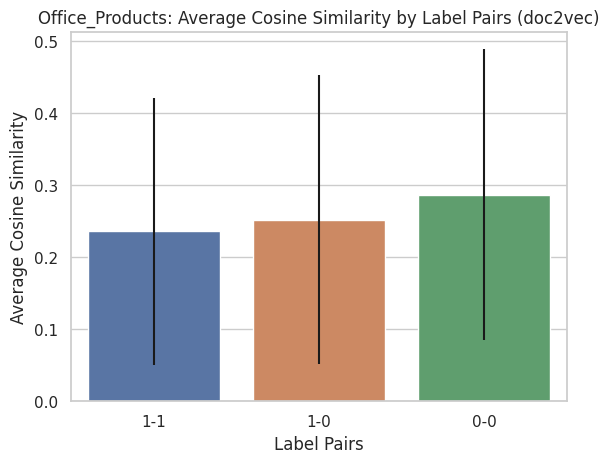

T-test between 1-1 and 1-0:-1.8632926655298776, p_value: 0.06256772078796347
T-test between 1-1 and 0-0:-5.893512394410136, p_value: 4.426704856470131e-09
T-test between 1-0 and 0-0:-3.8881054299659636, p_value: 0.00010432959944737529


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

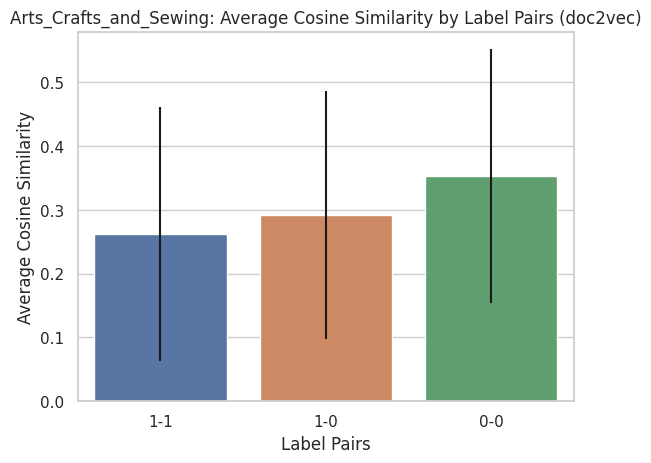

T-test between 1-1 and 1-0:-3.4077801074776897, p_value: 0.0006679231423815975
T-test between 1-1 and 0-0:-10.267593221223324, p_value: 3.878465515129591e-24
T-test between 1-0 and 0-0:-6.974763448729569, p_value: 4.149516913872058e-12


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

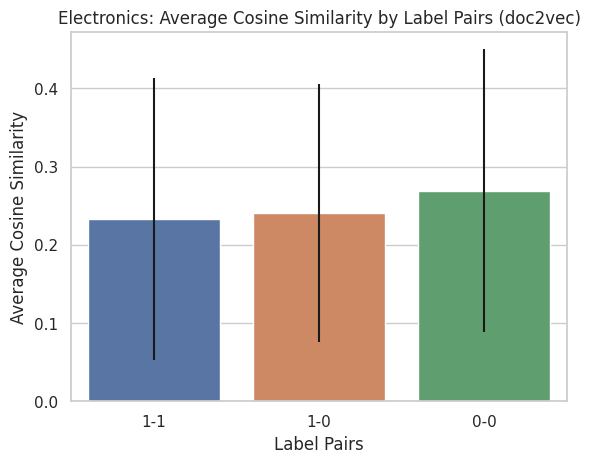

T-test between 1-1 and 1-0:-1.1336424846896267, p_value: 0.25708054817202614
T-test between 1-1 and 0-0:-4.53481081396862, p_value: 6.1072694068388135e-06
T-test between 1-0 and 0-0:-3.600987216572412, p_value: 0.000324746312009452


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

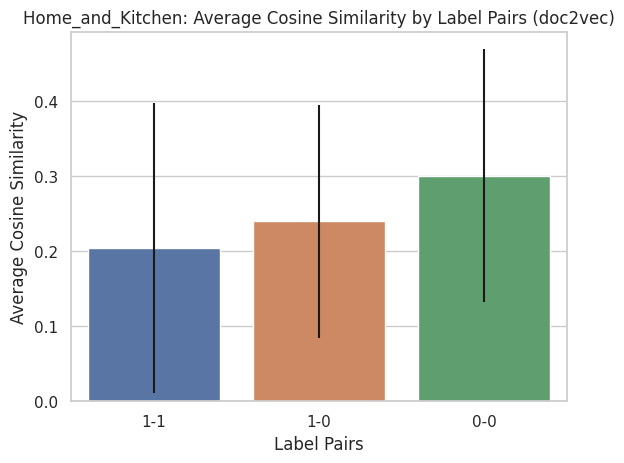

T-test between 1-1 and 1-0:-4.579954074596475, p_value: 4.937398560627075e-06
T-test between 1-1 and 0-0:-11.912817955124835, p_value: 1.1654174519398935e-31
T-test between 1-0 and 0-0:-8.379761649138157, p_value: 9.859350030364616e-17


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

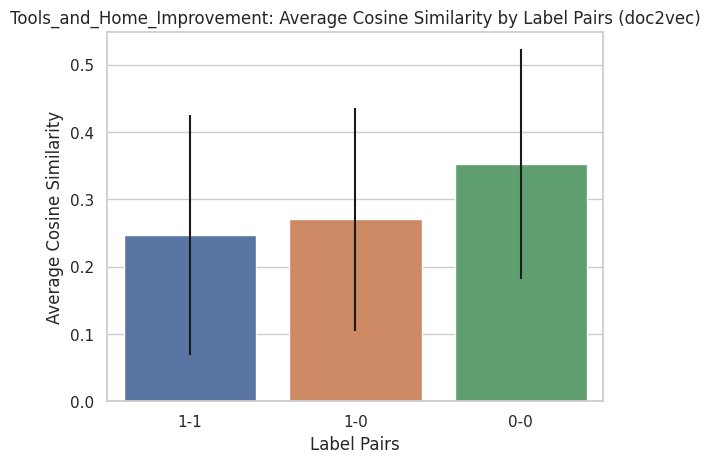

T-test between 1-1 and 1-0:-2.9926265790241873, p_value: 0.002799770651217749
T-test between 1-1 and 0-0:-13.458620890344752, p_value: 1.375646975683711e-39
T-test between 1-0 and 0-0:-10.914763474325785, p_value: 5.566295930107943e-27

Office_Products:
average_cosine_sim_1_1: 0.23620058693661058
std_cosine_sim_1_1: 0.1857331379228411
average_cosine_sim_1_0: 0.2523173106561785
std_cosine_sim_1_0: 0.20079508310021738
average_cosine_sim_0_0: 0.28732732085656837
std_cosine_sim_0_0: 0.20189190018010456

Arts_Crafts_and_Sewing:
average_cosine_sim_1_1: 0.26198366772385173
std_cosine_sim_1_1: 0.1989234211386082
average_cosine_sim_1_0: 0.29195434265585946
std_cosine_sim_1_0: 0.19436465866059316
average_cosine_sim_0_0: 0.3532307981930583
std_cosine_sim_0_0: 0.19851086000973603

Electronics:
average_cosine_sim_1_1: 0.23241605856045772
std_cosine_sim_1_1: 0.18024820069275896
average_cosine_sim_1_0: 0.24117144676555927
std_cosine_sim_1_0: 0.1647997485952281
average_cosine_sim_0_0: 0.26903983046999

In [ ]:
category_lists = ['Office_Products','Arts_Crafts_and_Sewing', 'Electronics', 'Home_and_Kitchen', 'Tools_and_Home_Improvement']

doc2vec_averages = plot_bars(datasets=category_lists, fix_indeces=False)

for category in doc2vec_averages:
  print(f'\n{category}:')
  for key in doc2vec_averages[category]:
    print(f'{key}: {doc2vec_averages[category][key]}')

# Add overall and n_words to the embedded dataframes

In [ ]:
def add_columns_from_category(path='/gdrive/My Drive/Amazon/results/', name=None, csv_file='balanced_labeled_dataset'):
    """
    Adds 'overall' and 'n_words' columns from total_reviews.csv (located in category-specific folders)
    to another DataFrame based on the 'old_index' column.

    Parameters:
    - path (str): The directory path where the category folders are located.
    - name (str): The name of the category-specific total_reviews.csv files.
    - df_1_name (str): The name of the DataFrame file (without the '.csv' extension) to which the columns will be added.

    Returns:
    - pd.DataFrame: A new DataFrame with the added columns.
    """

    # Read df_1 into a DataFrame
    df_1 = pd.read_csv(f"{path}{name}/{csv_file}.csv", index_col=0)

    df_modified = pd.DataFrame()


    # Process each unique category in df_1
    for category in df_1['category'].unique():
        # Read the total_reviews.csv for the specific category
        total_reviews = pd.read_csv(f"{path}/{category}/total_reviews.csv", index_col=0)


        # Create a subset DataFrame containing only the rows belonging to the current category
        df_subset = df_1[df_1['category'] == category]

        print(f'\ndf_subset before merge:\n')
        display(df_subset)
        # Perform the merge only on the rows of df_1 belonging to the current category
        df_subset = df_subset.merge(total_reviews[['overall', 'n_words']], left_on='Category_index', right_index=True, how='left')

        print(f'\ndf_subset after merge:\n')
        display(df_subset)
        # Append the modified subset DataFrame to df_modified
        df_modified = pd.concat([df_modified, df_subset])

        print(f'\ndf_modified:\n')
        display(df_modified)

    return df_modified


# Example usage:
name = "Full_Dataset"
csv_file = "full_balanced_labeled_dataset"
new_df = add_columns_from_category(name=name, csv_file=csv_file)


# Add the columns to the full datasets + change the index to multiindex according to category and old index

## Reindex to multiindex

In [ ]:
# Define the path and file names
path = '/gdrive/My Drive/Amazon/results/Full_Dataset/'
# file1 = 'full_balanced_labeled_dataset.csv'
file2 = 'full_balanced_labeled_dataset_doc2vec_embedded.csv'

# Read the CSV files into DataFrames
# df1 = pd.read_csv(f"{path}{file1}")
df2 = pd.read_csv(f"{path}{file2}")

# Drop 'Unnamed: 0' column from df1
# df1.drop(columns=['Unnamed: 0'], inplace=True)

# Add old index to df2 as a new column "embedding_index"
df2['embedding_index'] = df2.index

# # Display the DataFrames before setting the MultiIndex
# print("DataFrame df1 before setting MultiIndex:")
# display(df1)

print("DataFrame df2 before setting MultiIndex:")
display(df2)

# Set MultiIndex for both DataFrames
# df1.set_index(['category', 'Category_index'], inplace=True)
df2.set_index(['category', 'Category_index'], inplace=True)

print("DataFrame df2 after setting MultiIndex:")
display(df2)

# # Add 'overall' and 'n_words' columns from new_df to df2
df2 = df2.join(new_df[['overall', 'n_words']], how='left')

# Save the modified DataFrames back to CSV files
df2.to_csv(f"{path}{file2}")

# Generate matching reviews


In [ ]:
n_samples = 3  # Replace with your actual n_samples

# Extract samples where label is 1
label_1_reviews = df2[df2['label'] == 1].sample(n=n_samples, random_state=None)  # Removed random state to make it different every time

# Initialize an empty dataframe to store the matching samples
label_0_reviews = pd.DataFrame()

# Loop through each row in label_1_reviews to find the matching sample
for idx, row in label_1_reviews.iterrows():
    same_overall = df2[(df2['label'] == 0) & (df2['overall'] == row['overall'])].copy()
    if same_overall.empty:
        continue
    same_overall['abs_diff_n_words'] = np.abs(same_overall['n_words'] - row['n_words'])
    min_diff = same_overall['abs_diff_n_words'].min()
    closest_matches = same_overall[same_overall['abs_diff_n_words'] == min_diff]
    random_closest_match = closest_matches.sample(n=1, random_state=None).iloc[0]  # Random selection from closest matches
    label_0_reviews = pd.concat([label_0_reviews, pd.DataFrame([random_closest_match])])

display("Samples with label 1:")
display(label_1_reviews)

display("Matching samples with label 0:")
display(label_0_reviews)


'Samples with label 1:'

,,left_matching,reviewText,label,rank,doc2vec_embedding,embedding_index,overall,n_words
category,Category_index,,,,,,,,
Electronics,19329094,19329094,I'm using this for a camera PC cable to an ext...,1,0.0,[-0.06629575 -0.04336052 -0.01541463 0.009751...,11440,h,57.0
Arts_Crafts_and_Sewing,1027555,1027555,These work but for me it feels bulky and my hu...,1,0.0,[-0.06661195 0.06406189 -0.04954619 -0.118674...,5166,h,28.0
Home_and_Kitchen,5671526,5671526,I put the 3 cup measure in with a medley of wh...,1,0.0,[ 0.02579254 -0.07030225 -0.03106357 -0.056177...,17900,h,54.0


'Matching samples with label 0:'

,,left_matching,reviewText,label,rank,doc2vec_embedding,embedding_index,overall,n_words,abs_diff_n_words
Electronics,9228787,9228172,This is protecting my 4th grader's Kindle. Sh...,0,1.0,[-0.10767043 -0.10335932 0.12991032 -0.031757...,7141,h,57.0,0.0
Home_and_Kitchen,12891098,12891067,Love the feel of these sheets! This set is now...,0,1.0,[ 0.03728686 -0.21822828 -0.15006405 0.120965...,14602,h,28.0,0.0
Tools_and_Home_Improvement,8924924,6555805,"These are terrific ""must haves"" - For securing...",0,1.0,[ 0.25838685 0.06899209 0.13509184 0.059588...,22494,h,54.0,0.0


# Check balance

In [ ]:

def check_label_balance(path, file_names):
    """
    Check and print the label balance across categories for given CSV files.

    Parameters:
    - path (str): The base path to the directory containing the files.
    - file_names (list): A list of file names to be checked.
    """
    for file_name in file_names:
        # Load the CSV file
        df = pd.read_csv(path + file_name)

        # Group by category and label, then count the occurrences
        category_label_counts = df.groupby(['category', 'label']).size().unstack(fill_value=0)

        # Print the counts for each category
        print(f"Label counts for each category in '{file_name}':")
        print(category_label_counts)
        print("\n")

        # Check and print if any category is unbalanced
        print(f"Unbalanced categories in '{file_name}':")
        for category in category_label_counts.index:
            if category_label_counts.loc[category, 0] != category_label_counts.loc[category, 1]:
                print(f"Category '{category}' is unbalanced: Label 0: {category_label_counts.loc[category, 0]}, Label 1: {category_label_counts.loc[category, 1]}")
        print("-" * 50)

# Define the path and file names
path = '/gdrive/My Drive/Amazon/results/Full_Dataset/'
file_names = ['full_balanced_labeled_dataset.csv', 'full_balanced_labeled_dataset_doc2vec_embedded.csv']

# Check the label balance for both files
check_label_balance(path, file_names)

Label counts for each category in 'full_balanced_labeled_dataset.csv':
label                          0     1
category                              
Arts_Crafts_and_Sewing       710   772
Electronics                 2963  3030
Home_and_Kitchen            4850  5003
Office_Products             2047  2089
Tools_and_Home_Improvement  1033  1081


Unbalanced categories in 'full_balanced_labeled_dataset.csv':
Category 'Arts_Crafts_and_Sewing' is unbalanced: Label 0: 710, Label 1: 772
Category 'Electronics' is unbalanced: Label 0: 2963, Label 1: 3030
Category 'Home_and_Kitchen' is unbalanced: Label 0: 4850, Label 1: 5003
Category 'Office_Products' is unbalanced: Label 0: 2047, Label 1: 2089
Category 'Tools_and_Home_Improvement' is unbalanced: Label 0: 1033, Label 1: 1081
--------------------------------------------------
Label counts for each category in 'full_balanced_labeled_dataset_doc2vec_embedded.csv':
label                          0     1
category                              
Arts_Cr